# $k$-moyennes

Groupe de travail ML, 17/03/2021

**Joubine Aghili** 

📧 [aghili@unistra.fr](mailto:aghili@unistra.fr)

## Motivations

<img src="dataset_classes.png" width="400"/> 

- La méthode des $k$-moyennes (ou $k$-means 🇬🇧) est un cas d'algorithme de *clustering* consistant à **séparer des points en $k$ groupes**:
- Il s'agit d'un problème NP-difficile [[Mahaja et al.]](https://link.springer.com/chapter/10.1007/978-3-642-00202-1_24)
- Première trace fin des années 60, publié début années 80.
- Bien que basique il reste très utilisé en pratique car **rapide** et **simple** à implémenter. Il sépare *dans tous les cas*.

## Principe et propriétés

**Données** : $\mathbf{X}:=\{X_1, \ldots, X_n\}, X_i\in \mathbb{R}^d$, $K\ge0$

<center><img src="dataset_orig.png" width="400"/></center>

**But** 

- Construire $K$ points $(m_i)_{1\le i \le K}$ qui représenteront les classes $(\mathscr{C}_i)_{1\le i \le K}$:

$$\mathbf{C}:=(m_1,\ldots,m_K), \quad m_k \in \mathscr{C}_k,$$ 

qu'on appelera *centres*. 

- Ces classes sont telles que

$$ \mathscr{C}_1 \cup \cdots \cup \mathscr{C}_K = \mathbf{X}, \quad \mathscr{C}_i \cap \mathscr{C}_j = \emptyset.$$

<center><img src="dataset_classes.png" width="400"/></center>

- Les points $(m_i)$ sont obtenus comme minimiseurs d'une *fonction objectif* $J$ définie comme:
$$ J(\mathbf{C}) := \sum_{k=1}^K \sum_{X_i \in C_k} ||X_i - m_k||^2 \longrightarrow \min !$$

<center><img src="dataset.png" width="600"/></center>

L'appartenance d'un point $X$ à une classe $\mathscr{C}_i$ est définie grâce à la distance au centre $m_i$:


$$ X\in \mathscr{C}_i \Longleftrightarrow m_i =\mathrm{argmin}_{m\in\{ m_1,\ldots,m_K\}} {||X-m||^2}$$

<center><img src="dataset_classes.png" width="400"/></center>

**Remarque 1** Le problème $J(\mathbf{C}) := \sum_{k=1}^K \sum_{X_i \in C_k} ||X_i - m_k||^2 \longrightarrow \min !$

est équivalent au problème 

$$
\tilde{J}(\mathscr{C}_1, \ldots, \mathscr{C}_K) := \sum_{k=1}^K \frac{1}{|\mathscr{C}_k|^2} \left\{ \sum_{X_i\in \mathscr{C}_k,\, X_j\in\mathscr{C}_k}|| X_i - X_j ||^2\right\} \longrightarrow \min !,
$$
posé sur les classes.

<center><img src="dataset_voronoi.png" width="600"/></center>

**Remarque 2** Les points labelisé $X_i$ appartiennent aux celulles de Voronoi associées au $(m_1, \ldots, m_K)$.

Que se passe t-il si 

- les données sont pas séparables (eveloppes convexes s'intersectent) ? 
- données «non convexes» ?

<center><img src="dataset_double_banane.png" width="200"/></center>

**Remarque 3** La méthode de $K$-moyennes peut se voir comme 
$$ J(\mathbf{C},\mathbf{W}) := \sum_{i=1}^n|| \mathbf{C}W_i - X_i ||^2 \longrightarrow \min !$$
avec contraintes sur $\mathbf{W}$ : $|W_i|_{\text{nnz}}=1$ et $||W_i||_2=1$ (Ridge) pour $1\le i \le n$.
<center><img src="kmeans_CWX.png" width="100%"/></center>

$\mathbf{C}$: centres, $\mathbf{W}\in\mathscr{M}_{K,n}(\{0,1\})$ choix des centres, $\mathbf{X}$: données



💡 La méthode ACP s'obtient en **remplacant la contrainte** par $$\mathbf{C}^T\mathbf{C}=J_d$$ (point de vue minimisation de l'erreur de reconstruction):

$$ \min_{\substack{\mathbf{C},\mathbf{W} \\ \mathbf{C}^T\mathbf{C}=J_d}} J(\mathbf{C},\mathbf{W}) = \min_{\substack{\mathbf{C} \\ \mathbf{C}^T\mathbf{C}=J_d}} \sum_{i=1}^n|| \mathbf{C}\mathbf{C}^TX_i - X_i||^2= ..., $$

[après calculs](https://stats.stackexchange.com/a/10260) ($\mathbf{C}\mathbf{C}^T$ projecteur orthogonal, Pythagore, etc) on arrive à $$\sum_{i=1}^K C_i^T \mathbf{X}\mathbf{X}^T C_i \longrightarrow \max!$$ 


Ainsi (Cf. [ACP par C. Courtès]()), 

+ les $C_i$ sont $\vec{\text{vp}}$ de $\mathbf{X}\mathbf{X}^T$, les composantes principales du nouveau système de $K$ coordonnées représentant au mieu $\mathbf{X}$.
+ les valeurs propres permettent alors d'estimer $J$ directement.

On peut se rapprocher encore plus des $k$-moyennes en rajoutant des termes de pénalisation, voir [Generalizations of PCA](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/).

## Algorithme et exemple avec `sklearn`

La première apparition de cet algorithme remonte à [[Loyd 1957]](https://doi.org/10.1109/TIT.1982.1056489):

$\leadsto$ on construit intérativement une suite $\mathbf{C}^{(0)},\cdots,\mathbf{C}^{(n)}=\mathbf{C}^\star$ de centres

**Algorithme** $k$-moyennes:
1. [Choisir](#Initialisation:-alternatives) $k$ centres $\mathbf{C}=\{m_1,\ldots,m_K\}$,
2. Pour chaque $i\in\{1,...,K\}$, 
    - Trouver les points $X$ appartenant à $\mathscr{C}_i$
    - Remplacer le centre $m_i$ par le barycentre de $\mathscr{C}_i$ : $$m_i = \frac{1}{|C_i|}\sum_{x\in C_i} x,$$
3. Répéter 2 jusqu'à ce que $\mathbf{C}$ ne change plus.


<center><img src="algo.png" width="300"/></center>

### Un exemple simple avec la librairie `sklearn.KMeans`

On donne ici un exemple très simple, pour plus d'informations voir [la doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

Génration des données avec `sklearn.datasets.make_blobs`

In [33]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import matplotlib.pyplot as plt

# Generate data
n = 1000
X, _ = make_blobs(n_samples=n, centers=10, shuffle=True)   # X est (n, dim)

On initialise l'algorithme avec une initialisation `random` (aléatoire), il est possible d'initialiser avec la méthode `k-means++` beaucoup plus efficace.

In [34]:
# Compute K-means with random init
K = 10
km = KMeans(init='random',n_clusters=K, max_iter=100)
km.fit(X);
print('K-Means: iter={}\t J={} '.format(km.n_iter_, 0.5*km.inertia_))   # J = km.inertia_

K-Means: iter=10	 J=887.4294271444467 


A ce stade, l'algorithme a calculé un $\mathbf{C}^\star$, le resultat est stocké dans `km`. 
On peut avoir accès aux différentes données via les commandes:

|commande|description|
|---|---|
|`km.cluster_centers_`|$\mathbf{C}^\star$|
|`km.intertia_`| $J(\mathbf{C}^\star)$|
|`km.n_iter_`|Nombre d'itérations|
|`km.labels_`|Labels $i\in\{1,\ldots,K\}$ des points|

In [35]:
len(km.labels_)

1000

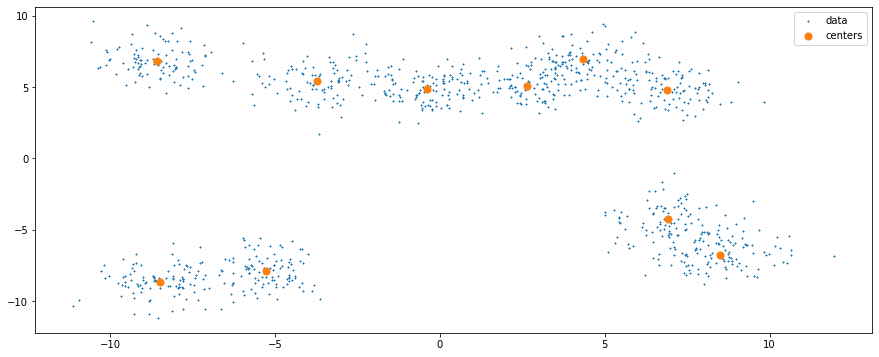

In [32]:
# Plot
C = km.cluster_centers_
plt.figure(figsize=(15,6))
plt.scatter(X[:,0], X[:,1], s=1, marker='x', label='data')
plt.scatter(C[:,0], C[:,1], s=50, marker='o', label='centers')
plt.legend()

### Le cas «double banane»

K-Means: K=0	iter=6	 J=199.22478961629224 
K-Means: K=1	iter=7	 J=133.2192085254942 
K-Means: K=2	iter=15	 J=85.85015254379127 
K-Means: K=3	iter=17	 J=64.46521448463939 
K-Means: K=4	iter=14	 J=43.90293158936504 
K-Means: K=5	iter=18	 J=34.76375378660224 


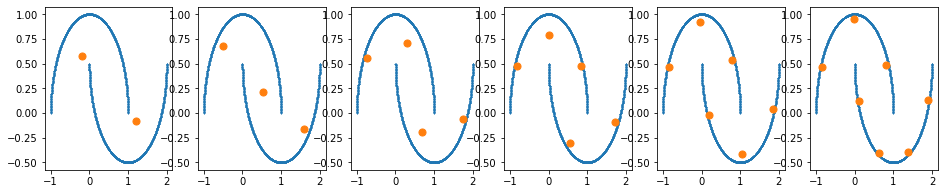

In [70]:
X,_ = make_moons(n_samples=n)
nfig = 6
fig, axs = plt.subplots(1,nfig, figsize=(16,3))
for k in range(nfig):
    K = k+2
    km = KMeans(init='random',n_clusters=K, max_iter=100)
    km.fit(X);
    print('K-Means: K={}\titer={}\t J={} '.format(k,km.n_iter_, 0.5*km.inertia_))   # J = km.inertia_
    C = km.cluster_centers_
    axs[k].scatter(X[:,0], X[:,1], s=1, marker='x', label='data')
    axs[k].scatter(C[:,0], C[:,1], s=50, marker='o', label='centers')
    #axs[k].legend()
fig.savefig('banana_K.png')

<center><img src="banana_K.png"/></center>

$n=10000$ points, $K=2,\ldots,7$.

## Propriétés et remarques sur l'algorithme

Remarques importantes:

- à chaque étape $J$ diminue strictement,
- l'algorithme de Loyd converge en un nombre fini d'itérations,

Quelques inconvénients (+ détails [ici](https://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means) ou [ici](https://staff.tarleton.edu/agapie/documents/cosc4360/notes_cosc_4360_11_ch_3_clustering.pdf))
- la sortie $\mathbf{C}^\star$ est [sensible à la condition initiale](#Initialisation-et-minima-locaux) et n'a **pas de garantie d'optimalité**, même sur des données sympathiques
- semble bien marcher pour des données séparables et «convexe»
- pas de méthode universelle pour choisir le «bon $K$»
- sensible à l'échelle (renormalisation nécessaire)

### Critères d'arrêt

Il existe plusieurs critères d'arrêts, par exemple:

- **Les centres n'ont pas changé par rapport à l'itération précédente**,
- les points restent dans la même classe,
- le nombre d'itérations maximum est atteint,
- le coût atteint franchit un seuil de tolérance : $J<\varepsilon_{\text{tol}}$.

### Initialisation et minima locaux

**Sensibilité forte**: Comme beaucoup d'algorithme itératifs, la condition initiale **peut amener à un minimum local**. 

Ici, on peut bricoler un exemple $1d$ pour s'en convaincre:

<img src="sensinit_1.png" width="700"/>

<img src="sensinit_2.png" width="800"/>

**Remarque**: Le rapport des coûts $$\frac{\tilde{J}_2}{J_2}=\frac{a^2}{c^2}$$ peut être arbitrairement grand si on initialise de la pire façon. 


<blockquote>$\leadsto$ Il n'y a alors aucune garantie d'avoir un optimum global.</blockquote>

**Stratégies d'initialisation courantes**:

- Totalement aléatoire $\leadsto$ peut donner de très mauvais résultats,
- Bruteforce aléatoire : recommencer plusieurs fois avec guess aléatoire $\leadsto$ long et sans garantie de résultat
- Preconditionnement : enlever les points abêrrants $\leadsto$ peut être long, pas forcément robuste
- Calculer un guess en réduisant l'aléas (`kmeans++`)

### Méthode k-means++

On définit $\mathbf{C}^{(0)}$ comme:

1. Initialisation: $\mathbf{C}^{(0)}=\emptyset$,
2. Tirer $m_1\in \mathbf{X}$ aléatoirement et l'ajouter: $$\mathbf{C}^{(0)}=\{ m_1 \},$$
3. Tant que $|\mathbf{C}^{(0)}|< K$, faire:
    - Définir $D(x):= \min_{s\in \mathbf{C}^{(0)}} || x - s ||^2$ pour tout $x\in \mathbf{X}\backslash\mathbf{C}^{(0)}$
    - Tirer aléatoirement $m\in\mathbf{X}\backslash\mathbf{C}^{(0)}$ selon $p(x)=\mathcal{N}D(x)$ et le rajouter à $\mathbf{C}^{(0)}$

En pratique, il est **peu avantageux sur de petits cas tests**:

Coût $J$ vs. $K$ normalisé:

<center> <img src="kmeans_small.png" width="100%" /> </center>

Ici un dataset de $n=10000$ points répartis sur $50$ clusters dans $R^2$. 

En revanche, **sur des gros jeux de données, la différence est significative** [[Arthur & Vassilvitskii 2006]](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf)

<center><img src="kmeanspp.png" width="550"/></center>

où $J$ = $\phi$ et l'espérance $\mathbb{E}(J)=$«Average $\phi$».


## Variants

L'algorithme $k$-means a plusieurs variants:

| nom | utilité|
|-----|---|
|$k$-median| si on possède uniquement les distances $d(X_i,X_j)$ pas de système de coordonnées,|
|weighted $k$-means | rajout de poids sur les données |
| kernel $k$-means [[Dhillon et al 2004]](https://www.cs.utexas.edu/users/inderjit/public_papers/kdd_spectral_kernelkmeans.pdf) |  version avec *un noyau* $k(X_i,X_j)$  |
| soft $k$-means | on assigne les points aux classes «en probabilité» |

## Bibliographie

- [Cours Princeton](https://www.cs.princeton.edu/courses/archive/spr08/cos435/Class_notes/clustering2_toPost.pdf)
- [Wikipédia](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm)
- [Vidéo YouTube Tübingen ML](https://www.youtube.com/watch?v=SQUjEPcm508) 
- [`sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
- [désavantages de $k$-means](https://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means)
- [Quelques notes et tests](https://staff.tarleton.edu/agapie/documents/cosc4360/notes_cosc_4360_11_ch_3_clustering.pdf)
- [Réecriture ACP](https://stats.stackexchange.com/a/10260)
- [PCA & beyond](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/)